In [49]:
# GTM Package including GTM and the plot functions
from gtm import *
# Helper functions to create simulation data and analyze it
from demos.pyvinecopulib_simulation_helpers import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [2]:
set_seeds(1)

### 1. Sample Data

In [3]:
rvine_structure = pv.RVineStructure.simulate(10)

In [4]:
D = 10  # dimension
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)

In [5]:
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)


In [6]:
df = compute_conditional_dependence_table(vine_model)
df

,tree,edge,conditioned variables,conditioning variables,var_types,family,rotation,parameters,df,tau,conditioned variable 1,conditioned variable 2,var_row,var_col,dependence
0,1,1,7 1,,"c, c",Joe,270.0,5.44,1.0,-0.70,7,1,7,1,1
1,1,2,2 10,,"c, c",Student,0.0,"0.42, 2.00",2.0,0.28,2,10,10,2,1
2,1,3,6 10,,"c, c",Gaussian,0.0,-0.34,1.0,-0.22,6,10,10,6,1
3,1,4,5 10,,"c, c",Joe,180.0,3.46,1.0,0.57,5,10,10,5,1
4,1,5,8 10,,"c, c",Frank,0.0,-5.18,1.0,-0.47,8,10,10,8,1
5,1,6,4 3,,"c, c",Frank,0.0,-3.92,1.0,-0.38,4,3,4,3,1
6,1,7,1 10,,"c, c",Frank,0.0,-3.04,1.0,-0.31,1,10,10,1,1
7,1,8,3 10,,"c, c",Frank,0.0,5.17,1.0,0.47,3,10,10,3,1
8,1,9,9 10,,"c, c",Student,0.0,"-0.36, 2.00",2.0,-0.23,9,10,10,9,1
9,2,1,7 10,1,"c, c",Joe,270.0,3.67,1.0,-0.59,7,10,10,7,1


In [7]:
#creating a table to copare the true dependence structure later on to what the gtm learned
df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/3150062370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_row"] = df_true_structure_sub["var_row"] - 1
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/3150062370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_structure_sub["var_col"] = df_true_structure_sub["var_col"] - 1


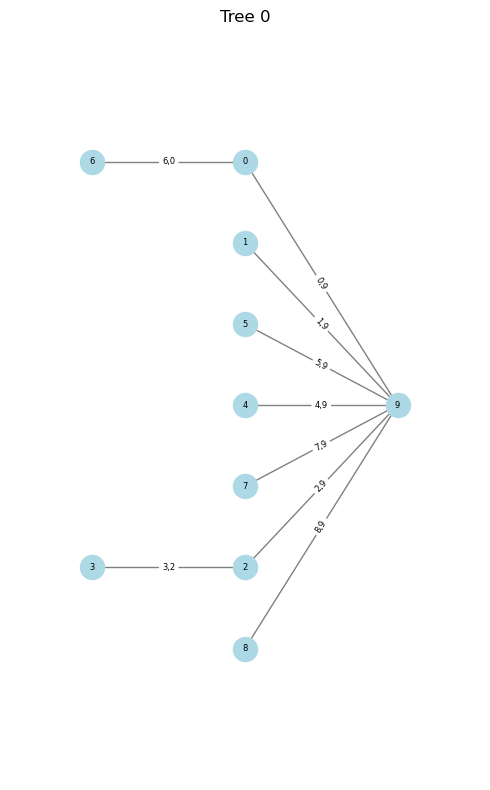

In [8]:
vine_model.plot(tree=[0])

In [9]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [10]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/1520218578.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/1520218578.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/1520218578.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [11]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [12]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_66388/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [13]:
#_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [14]:
#_ = plot_marginals(simulated_data_train)

In [15]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [16]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 10])

### 2. Define Model

In [17]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=40,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=10,
    calc_method_bspline="deBoor",
    affine_decorr_layer=False,
    span_restriction="reluler",
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [21]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"], #[0],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params= False #study.best_params["lambda_penalty_params"] #False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-22 16:50:06,150] A new study created in RDB with name: no-name-4d81e84a-1b21-4824-a3dc-01ea12a658c3


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 25.104129248666837   pensecondridge_opt: 23.994565434781308   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
 11%|█▏        | 114/1000 [00:23<03:05,  4.79it/s]
[I 2025-05-22 16:50:30,599] Trial 0 finished with value: -6.8281779289245605 and parameters: {'penfirstridge': 25.104129248666837, 'pensecondridge': 23.994565434781308}. Best is trial 0 with value: -6.8281779289245605.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.23786016337484   pensecondridge_opt: 28.26384183374429   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 62/1000 [00:14<03:33,  4.40it/s]
[I 2025-05-22 16:50:44,894] Trial 1 finished with value: -7.281529426574707 and parameters: {'penfirstridge': 16.23786016337484, 'pensecondridge': 28.26384183374429}. Best is trial 0 with value: -6.8281779289245605.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.19910622875556377   pensecondridge_opt: 12.864957235244843   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 20%|██        | 202/1000 [00:45<03:00,  4.43it/s]
[I 2025-05-22 16:51:30,621] Trial 2 finished with value: -6.721148490905762 and parameters: {'penfirstridge': 0.19910622875556377, 'pensecondridge': 12.864957235244843}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 21.38591220150713   pensecondridge_opt: 27.917858845787332   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▍         | 48/1000 [00:10<03:32,  4.48it/s]
[I 2025-05-22 16:51:41,463] Trial 3 finished with value: -7.269013404846191 and parameters: {'penfirstridge': 21.38591220150713, 'pensecondridge': 27.917858845787332}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 26.48550564358533   pensecondridge_opt: 15.995686859555507   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▌         | 54/1000 [00:12<03:31,  4.46it/s]
[I 2025-05-22 16:51:53,727] Trial 4 finished with value: -7.196055889129639 and parameters: {'penfirstridge': 26.48550564358533, 'pensecondridge': 15.995686859555507}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.408399294593017   pensecondridge_opt: 13.025308685220324   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 84/1000 [00:23<04:16,  3.57it/s]
[I 2025-05-22 16:52:17,424] Trial 5 finished with value: -6.983153343200684 and parameters: {'penfirstridge': 2.408399294593017, 'pensecondridge': 13.025308685220324}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.2946439172376414   pensecondridge_opt: 28.962359966849522   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 60/1000 [00:16<04:18,  3.64it/s]
[I 2025-05-22 16:52:34,095] Trial 6 finished with value: -7.1110334396362305 and parameters: {'penfirstridge': 0.2946439172376414, 'pensecondridge': 28.962359966849522}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.466002517155633   pensecondridge_opt: 14.70571929813131   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 79/1000 [00:21<04:10,  3.68it/s]
[I 2025-05-22 16:52:55,724] Trial 7 finished with value: -6.964749336242676 and parameters: {'penfirstridge': 16.466002517155633, 'pensecondridge': 14.70571929813131}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 27.491488312561568   pensecondridge_opt: 20.877984294595887   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▌         | 51/1000 [00:12<03:45,  4.21it/s]
[I 2025-05-22 16:53:07,991] Trial 8 finished with value: -7.25343132019043 and parameters: {'penfirstridge': 27.491488312561568, 'pensecondridge': 20.877984294595887}. Best is trial 2 with value: -6.721148490905762.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.010196243020976   pensecondridge_opt: 5.813901439704735   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 21%|██        | 211/1000 [00:48<02:59,  4.39it/s]
[I 2025-05-22 16:53:56,223] Trial 9 finished with value: -6.705333709716797 and parameters: {'penfirstridge': 8.010196243020976, 'pensecondridge': 5.813901439704735}. Best is trial 9 with value: -6.705333709716797.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 9.718994502031027   pensecondridge_opt: 0.2681760998490086   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 79/1000 [00:19<03:47,  4.05it/s]
[I 2025-05-22 16:54:15,879] Trial 10 finished with value: -7.084171772003174 and parameters: {'penfirstridge': 9.718994502031027, 'pensecondridge': 0.2681760998490086}. Best is trial 9 with value: -6.705333709716797.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 17.608510288295157   pensecondridge_opt: 6.473275906270323   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 21%|██        | 211/1000 [00:49<03:04,  4.27it/s]
[I 2025-05-22 16:55:05,468] Trial 11 finished with value: -6.648456573486328 and parameters: {'penfirstridge': 17.608510288295157, 'pensecondridge': 6.473275906270323}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 25.56816469075453   pensecondridge_opt: 2.325322691144164   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 12%|█▏        | 115/1000 [00:26<03:26,  4.28it/s]
[I 2025-05-22 16:55:32,479] Trial 12 finished with value: -6.835743427276611 and parameters: {'penfirstridge': 25.56816469075453, 'pensecondridge': 2.325322691144164}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 1.4835258787668844   pensecondridge_opt: 3.5586162865578626   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 15%|█▌        | 150/1000 [00:33<03:10,  4.46it/s]
[I 2025-05-22 16:56:06,281] Trial 13 finished with value: -6.849526405334473 and parameters: {'penfirstridge': 1.4835258787668844, 'pensecondridge': 3.5586162865578626}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.00872451079815   pensecondridge_opt: 7.449043141800514   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 16%|█▋        | 164/1000 [00:40<03:28,  4.01it/s]
[I 2025-05-22 16:56:47,401] Trial 14 finished with value: -6.720091819763184 and parameters: {'penfirstridge': 16.00872451079815, 'pensecondridge': 7.449043141800514}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.697862383787184   pensecondridge_opt: 22.536015577150703   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 11%|█         | 110/1000 [00:26<03:38,  4.08it/s]
[I 2025-05-22 16:57:14,530] Trial 15 finished with value: -6.840102672576904 and parameters: {'penfirstridge': 8.697862383787184, 'pensecondridge': 22.536015577150703}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 16.831212566499453   pensecondridge_opt: 0.1661790403425334   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 18%|█▊        | 184/1000 [00:42<03:07,  4.36it/s]
[I 2025-05-22 16:57:56,877] Trial 16 finished with value: -6.712996959686279 and parameters: {'penfirstridge': 16.831212566499453, 'pensecondridge': 0.1661790403425334}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 12.962691916642484   pensecondridge_opt: 7.746832033955146   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 20%|█▉        | 197/1000 [00:47<03:13,  4.15it/s]
[I 2025-05-22 16:58:44,465] Trial 17 finished with value: -6.672553539276123 and parameters: {'penfirstridge': 12.962691916642484, 'pensecondridge': 7.746832033955146}. Best is trial 11 with value: -6.648456573486328.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 24.980936519024027   pensecondridge_opt: 9.478651662035217   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 22%|██▏       | 223/1000 [00:52<03:03,  4.24it/s]
[I 2025-05-22 16:59:37,282] Trial 18 finished with value: -6.635349750518799 and parameters: {'penfirstridge': 24.980936519024027, 'pensecondridge': 9.478651662035217}. Best is trial 18 with value: -6.635349750518799.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 27.02327427860537   pensecondridge_opt: 9.593425714651843   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 14%|█▍        | 139/1000 [00:32<03:20,  4.28it/s]
[I 2025-05-22 17:00:09,898] Trial 19 finished with value: -6.7256999015808105 and parameters: {'penfirstridge': 27.02327427860537, 'pensecondridge': 9.593425714651843}. Best is trial 18 with value: -6.635349750518799.


hyperparameter_tuning done


In [18]:
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            15,
                            2,
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params= False #study.best_params["lambda_penalty_params"] #False

In [19]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
 13%|█▎        | 130/1000 [00:03<00:26, 32.89it/s]


In [20]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS", learning_rate=1,
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

 19%|█▉        | 193/1000 [00:33<02:18,  5.83it/s]


### 4. Compare Fit to Benchmarks

In [21]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [22]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [23]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.6142
KLD Gaussian Train Data:  3.2696
KLD Copula   Train Data:  0.0084
KLD GTM      Test  Data:  1.0833
KLD Gaussian Test  Data:  3.3092
KLD Copula   Test  Data:  0.0438


In [24]:
# save model
#torch.save(model, "10D_rvine_model_state_dict.pth")
#model = torch.load("./10D_rvine_model_state_dict.pth")

### 5. Evaluate and Plot GTM Results

In [25]:
model.approximate_transformation_inverse()

In [26]:
synthetic_samples = model.sample(2000)
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)

In [27]:
#_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation_matrix_train,metric_type="precision_matrix")

#### does the GTM identify the conditional independence structure?

In [29]:
conditional_independence_table = model.compute_conditional_independence_table(
                                        y = None,
                                        x = False,
                                        evaluation_data_type = "samples_from_model",
                                        num_processes=4,
                                        sample_size = 5000,
                                        num_points_quad=20,
                                        optimized=True,
                                        copula_only=False,
                                        min_val=-8,
                                        max_val=8)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 6 with var_row_num 4 and var_col_num 0.


/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/sr

Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 18 with var_row_num 6 and var_col_num 3.
Processing row 21 with var_row_num 7 and var_col_num 0.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 19 with var_row_num 6 and var_col_num 4.
Processing row 22 with var_row_num 7 and var_col_num 1.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 17 with var_row_num 6 and var_col_num 2

In [38]:
# merging together computed metrics for conditional independence table and actual structure of the simulation data for comparison
merged = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"] # or "inner", "left", depending on your needs
)
merged.shape


(45, 9)

In [39]:
merged.sort_values("iae",ascending=False) #.sort_values("abs_mean",ascending=False) #.sort_values("iae",ascending=False)

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
38,9,2,3.624477,13.794410,0.658751,0.441811,0.878687,0.866287,1
42,9,6,2.200791,5.540302,0.362587,0.136574,0.378671,0.860712,1
15,6,0,7.038741,56.124306,0.940714,0.885794,3.356807,0.790776,1
36,9,0,2.862352,9.597827,0.323245,0.111041,0.370006,0.780183,1
30,8,2,2.441384,6.784243,0.554259,0.320982,0.793396,0.737579,1
40,9,4,3.675336,15.468559,0.727214,0.537641,1.185591,0.678889,1
8,4,2,2.605496,7.334979,0.684766,0.473425,0.513496,0.581441,1
44,9,8,1.149970,1.730498,0.207519,0.055558,0.442774,0.566283,1
31,8,3,1.570043,2.533107,0.520888,0.276734,0.580847,0.559309,0
26,7,5,1.448094,2.141280,0.717184,0.516534,0.350275,0.447577,1


In [50]:
merged.sort_values("cond_correlation_abs_mean",ascending=False)

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
15,6,0,7.038741,56.124306,0.940714,0.885794,3.356807,0.790776,1
40,9,4,3.675336,15.468559,0.727214,0.537641,1.185591,0.678889,1
26,7,5,1.448094,2.141280,0.717184,0.516534,0.350275,0.447577,1
8,4,2,2.605496,7.334979,0.684766,0.473425,0.513496,0.581441,1
38,9,2,3.624477,13.794410,0.658751,0.441811,0.878687,0.866287,1
30,8,2,2.441384,6.784243,0.554259,0.320982,0.793396,0.737579,1
31,8,3,1.570043,2.533107,0.520888,0.276734,0.580847,0.559309,0
41,9,5,1.527595,2.465228,0.401093,0.166864,0.304046,0.431301,1
42,9,6,2.200791,5.540302,0.362587,0.136574,0.378671,0.860712,1
43,9,7,1.296808,1.785274,0.348225,0.126731,0.176308,0.391962,1


In [40]:
merged.corr("spearman")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.468889,0.464364,0.459035,0.456171,0.448379,0.484878,0.519245,0.588760
var_col,0.468889,1.000000,0.014586,0.003796,0.108165,0.103636,0.029705,0.067670,0.155219
precision_abs_mean,0.464364,0.014586,1.000000,0.997760,0.950198,0.948617,0.973123,0.977207,0.734083
precision_square_mean,0.459035,0.003796,0.997760,1.000000,0.942688,0.942161,0.971410,0.978524,0.730554
cond_correlation_abs_mean,0.456171,0.108165,0.950198,0.942688,1.000000,0.997892,0.924769,0.914756,0.734083
cond_correlation_square_mean,0.448379,0.103636,0.948617,0.942161,0.997892,1.000000,0.926482,0.913702,0.730554
kld,0.484878,0.029705,0.973123,0.971410,0.924769,0.926482,1.000000,0.971014,0.730554
iae,0.519245,0.067670,0.977207,0.978524,0.914756,0.913702,0.971014,1.000000,0.727025
dependence,0.588760,0.155219,0.734083,0.730554,0.734083,0.730554,0.730554,0.727025,1.000000


In [41]:
merged.corr("pearson")

,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
var_row,1.000000,0.500000,0.313990,0.136642,0.337374,0.229923,0.204762,0.483034,0.525150
var_col,0.500000,1.000000,-0.055454,-0.151068,0.067078,-0.000748,-0.085888,0.093986,0.200386
precision_abs_mean,0.313990,-0.055454,1.000000,0.912995,0.899513,0.915940,0.933595,0.850070,0.616119
precision_square_mean,0.136642,-0.151068,0.912995,1.000000,0.716868,0.827302,0.978361,0.597232,0.398593
cond_correlation_abs_mean,0.337374,0.067078,0.899513,0.716868,1.000000,0.963376,0.794271,0.838288,0.670810
cond_correlation_square_mean,0.229923,-0.000748,0.915940,0.827302,0.963376,1.000000,0.880437,0.735732,0.562201
kld,0.204762,-0.085888,0.933595,0.978361,0.794271,0.880437,1.000000,0.667003,0.465372
iae,0.483034,0.093986,0.850070,0.597232,0.838288,0.735732,0.667003,1.000000,0.738113
dependence,0.525150,0.200386,0.616119,0.398593,0.670810,0.562201,0.465372,0.738113,1.000000


In [52]:
auc_iae = roc_auc_score(merged["dependence"], merged["iae"])
auc_kld = roc_auc_score(merged["dependence"], merged["kld"])
auc_corr = roc_auc_score(merged["dependence"], merged["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged["dependence"], merged["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9327731092436975
AUC KLD                    : 0.9348739495798319
AUC Conditional Correlation: 0.9369747899159664
AUC Precision Matrix       : 0.9369747899159664


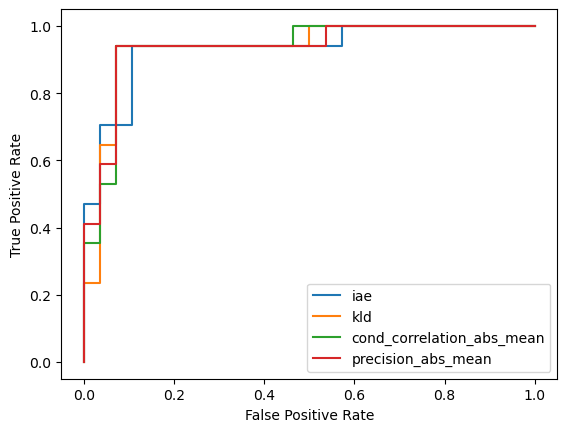

In [57]:
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["iae"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["kld"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged["dependence"], merged["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Looking at the model splines

In [34]:
#_ = plot_splines(model.transformation,simulated_data_train)

In [35]:
#_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

In [36]:
#_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

In [37]:
#_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)